In [1]:
from spacerocks import SpaceRock, Units

from astroquery.jplhorizons import Horizons

from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
units = Units()
units.timescale = 'tdb' # JPL gives elements in TDB. This actually matters for precise ephemerides.
units.current()

Quantity             Unit           
---------------------------------------
distance             AU             
angle                deg            
timescale            tdb            
timeformat           None           
speed                AU / d         
size                 km             
density              g / cm3        
mass                 kg             
ra                   deg            
dec                  deg            


In [3]:
rock = SpaceRock(a=2.220499558676716E+00, 
                 e=1.894657357257981E-01, 
                 inc=6.400015246723842E+00, 
                 node=3.758603673159217E+01, 
                 arg=3.480337244166024E+02, 
                 M=1.133480048255620E+01, 
                 epoch=2459396.5, 
                 H=14.87,
                 name='Valjean',
                 origin='sun',
                 units=units)

In [4]:
startdate = Time('2000-01-01', scale='utc', format='iso')
testdates = Time(np.arange(startdate.jd, startdate.jd + 50 * 365.25, 30), scale='utc', format='jd')

In [5]:
units.timescale = 'utc'
prop, planets, sim = rock.propagate(epochs=testdates.jd, model=3, units=units)

/usr/local/bin/anaconda/envs/spacerocks/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 280 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/bin/anaconda/envs/spacerocks/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 280 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [6]:
obs = prop.observe(obscode='W84')

In [7]:
rock_id = 'Valjean'
ephem_Horizons = Horizons(id=rock_id, location='W84',
                          epochs={'start':testdates[0].iso, 
                                  'stop':testdates[-1].iso, 
                                  'step':'30d'}).ephemerides()

/usr/local/bin/anaconda/envs/spacerocks/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [8]:
pos_Horizons = SkyCoord(ephem_Horizons['RA'], ephem_Horizons['DEC'], frame='icrs', unit=(u.deg, u.deg))
pos_pred = SkyCoord(obs.ra.deg, obs.dec.deg, frame='icrs', unit=(u.deg, u.deg))
sep = pos_pred.separation(pos_Horizons)

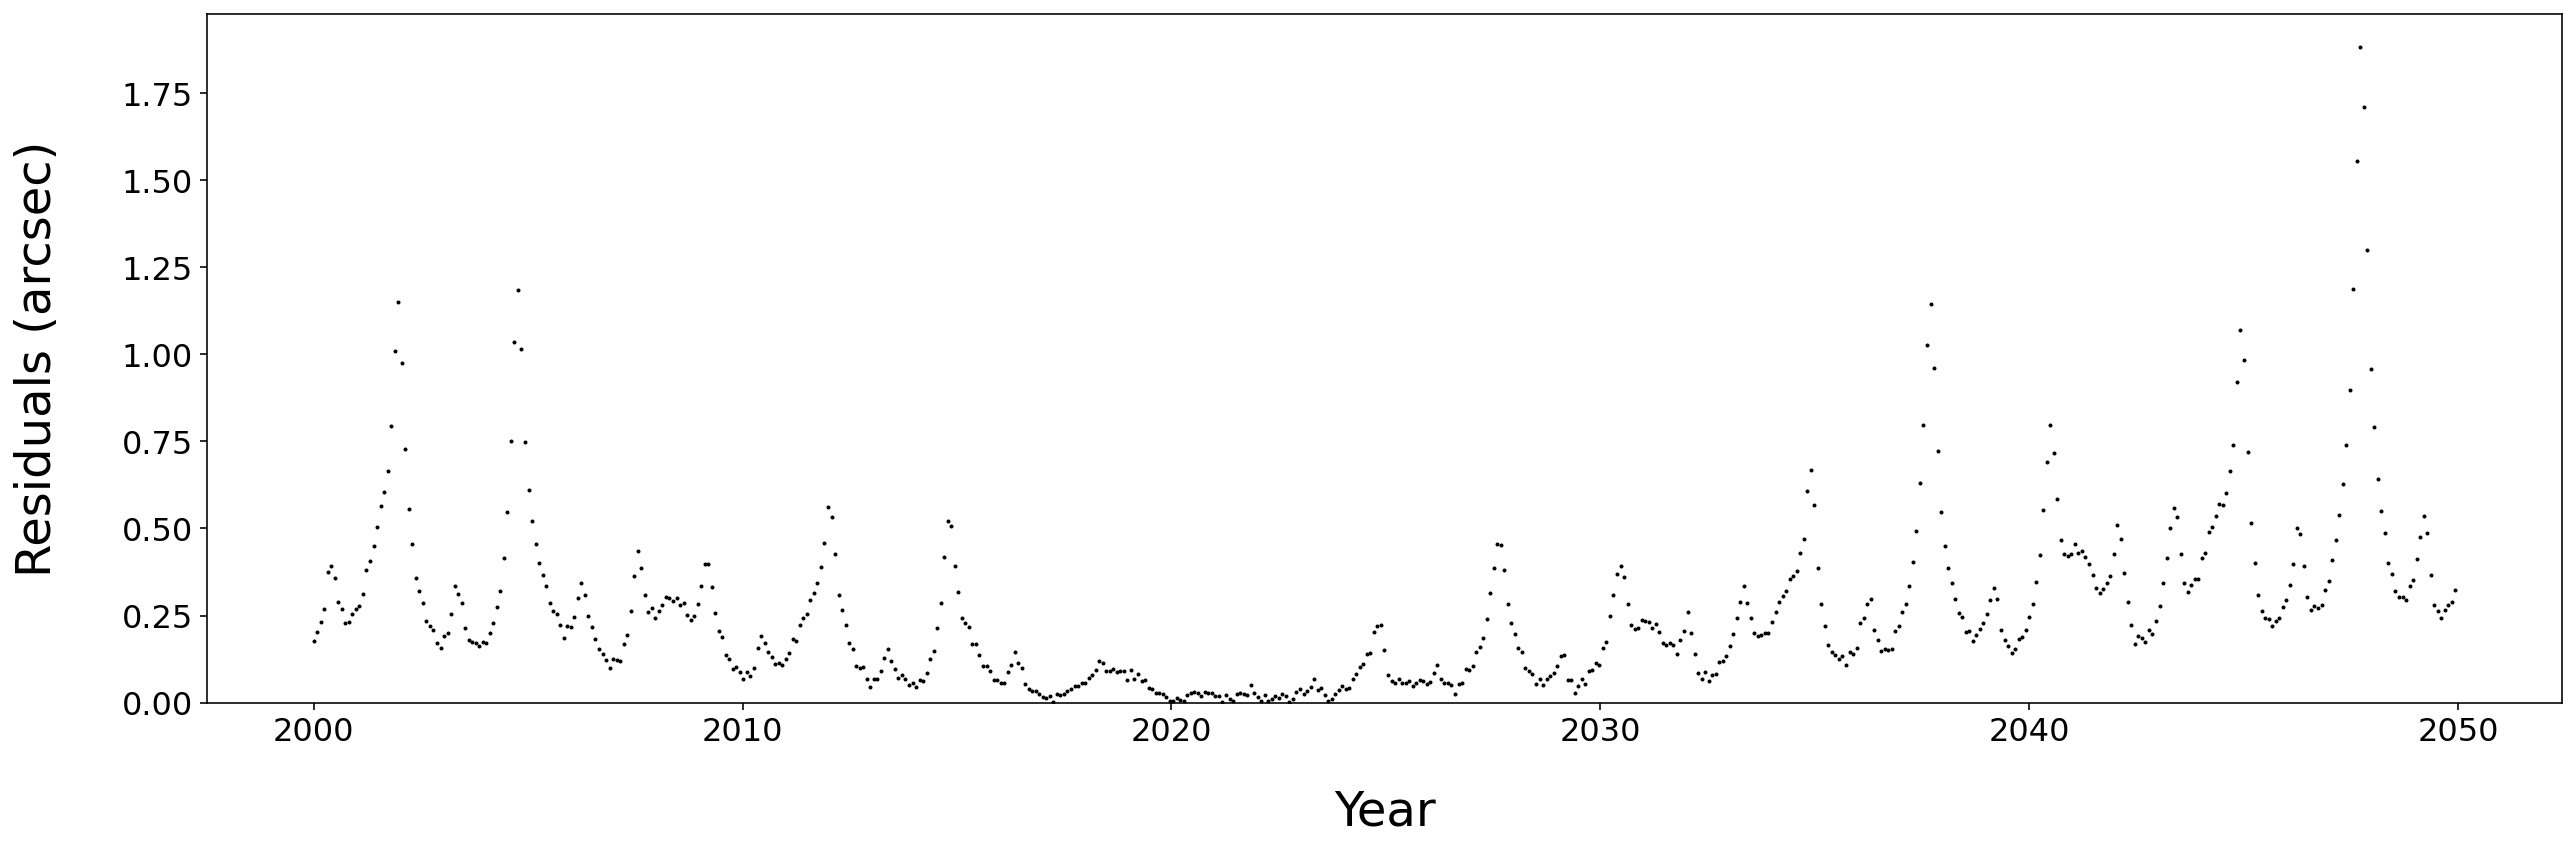

In [9]:
fig, ax = plt.subplots(figsize=(18, 6))

ax.scatter(prop.epoch.decimalyear, sep.arcsec, color='black', s=1)

ax.tick_params(labelsize=16)
ax.set_xlabel('Year', fontsize=24, labelpad=20)
ax.set_ylabel('Residuals (arcsec)', fontsize=24, labelpad=30)
ax.set_ylim(bottom=0)
fig.tight_layout()